In [57]:
from datetime import datetime
from siphon.catalog import TDSCatalog
import xarray as xr
import numpy as np
import metpy
from metpy.plots import ctables
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [58]:
radar = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/nexrad/composite/unidata/latest.xml')
data = radar.datasets[0].remote_access(use_xarray=True)
data = data.metpy.parse_cf()

ds = data['Base_reflectivity_surface_layer'].squeeze()
plot_proj = ds.metpy.cartopy_crs
location = plot_proj.transform_point(-82.60, 30.82, ccrs.PlateCarree())
x, y = location

In [59]:
data_time = ds.time.values
print(data_time)
current_time = np.datetime64(datetime.utcnow())
print(current_time)

time_delta = current_time - data_time
time_delta = time_delta.astype('timedelta64[m]')
print(time_delta)

print('True') if time_delta > 20 else print('False')

2021-03-25T01:50:00.000000000
2021-03-25T01:56:09.002522
6 minutes
False


In [60]:
point = ds.squeeze().metpy.sel(x=x, y=y, method='nearest')
print(point.values)

15.0


In [61]:
x_vals = []
y_vals = []

def convert_latlon_to_xy(ds, lat, lon):
    plot_proj = ds.metpy.cartopy_crs
    location = plot_proj.transform_point(lon, lat, ccrs.PlateCarree())
    x, y = location
    return x, y

def get_grid_value(ds, x, y):
    point = ds.squeeze().metpy.sel(x=x, y=y, method='nearest')
    return point.values

def get_grid_values(ds, x_UL, x_LR, y_UL, y_LR):
    points = ds.metpy.sel(x=slice(x_UL, x_LR), y=slice(y_LR, y_UL))
    return points.values

# pt_x, pt_y = convert_latlon_to_xy(ds, 30.82, -82.60)
# value = get_grid_value(ds, pt_x, pt_y)
# print(value)

x_UL, y_UL = convert_latlon_to_xy(ds, 35, -85)
x_LR, y_LR = convert_latlon_to_xy(ds, 30, -80)

raw_data = get_grid_values(ds, x_UL, x_LR, y_UL, y_LR)
raw_data

np.any(raw_data[:, :] >= 50)

False

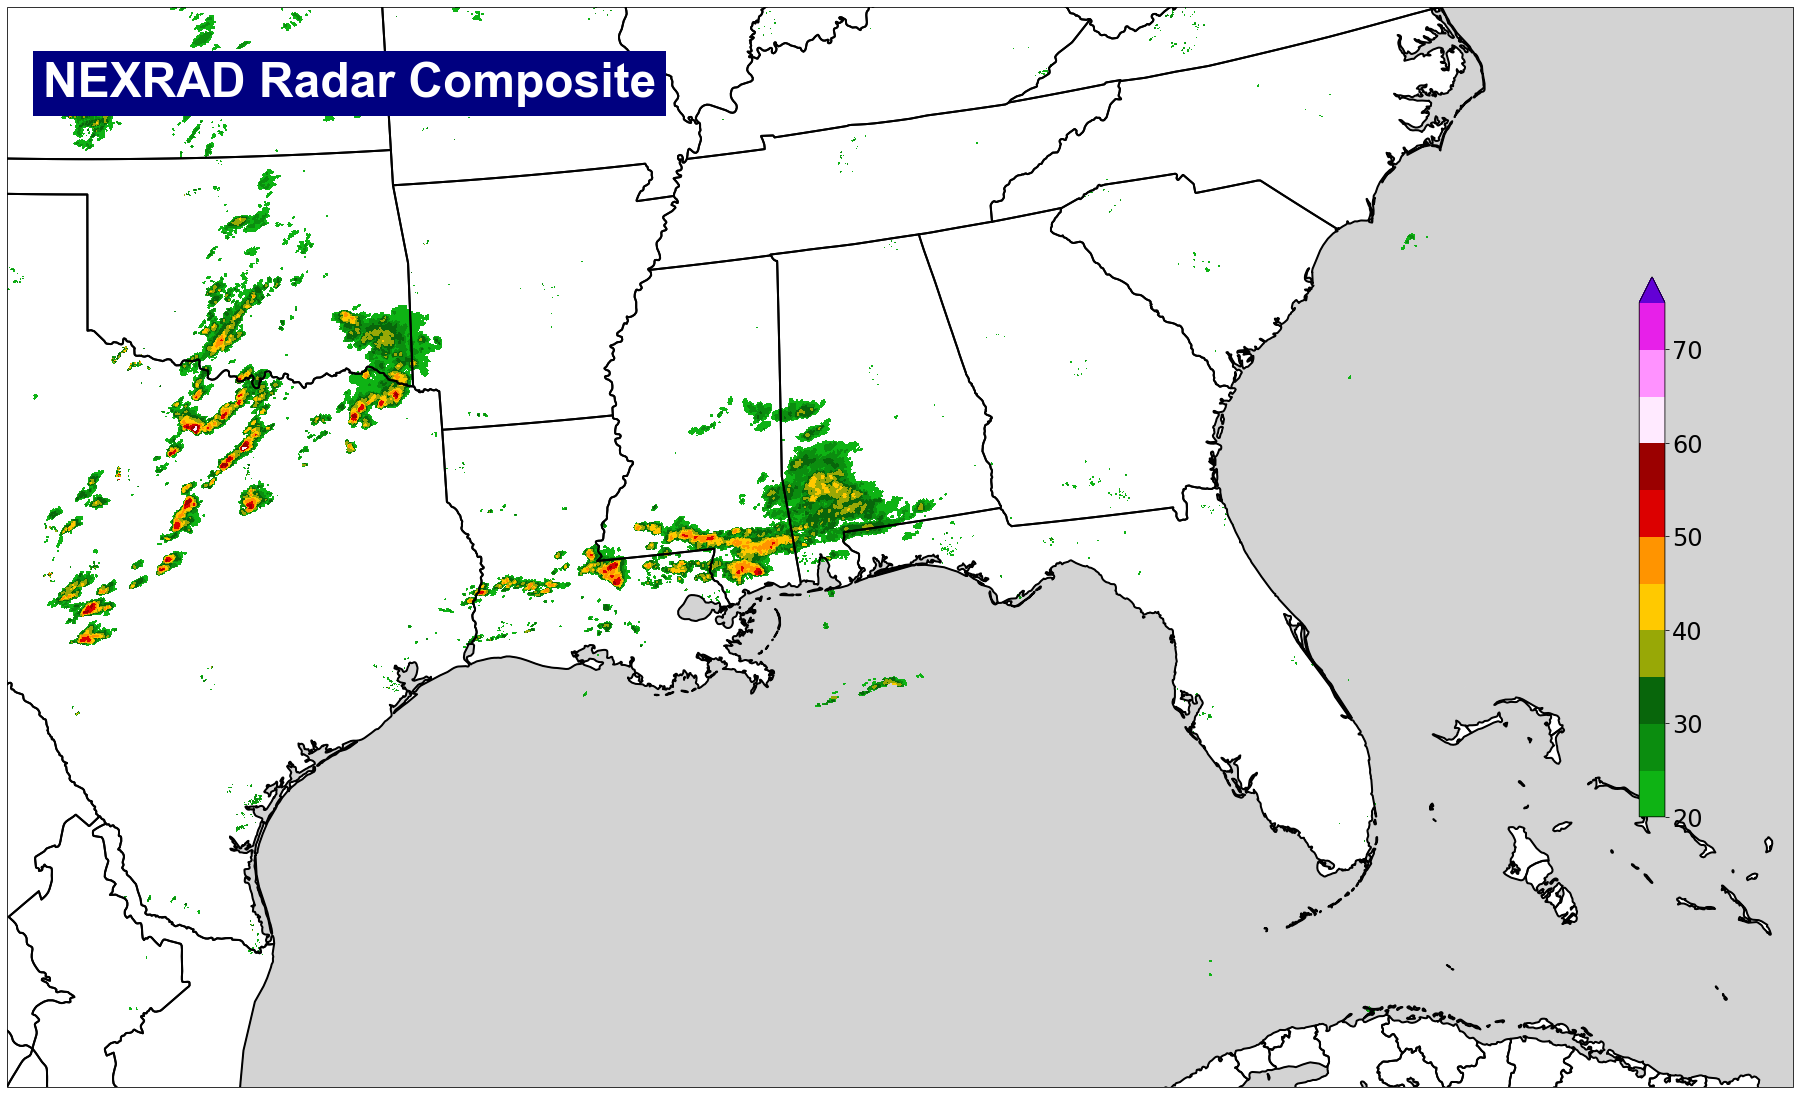

In [77]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=plot_proj)
ax.set_extent((-97, -78, 24, 37), crs=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2)
ax.set_adjustable('datalim')

# Display Banner
plt.text(0.02, 0.95, s='NEXRAD Radar Composite',
         fontname='Arial', fontsize=48, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none', 'boxstyle':'square,pad=0.2'},
         transform=ax.transAxes, zorder=10, va='top')

norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)

contour = ax.contourf(ds.metpy.x, ds.metpy.y, ds, np.arange(20, 80, 5), 
                      cmap=cmap, norm=Normalize(-30, 80), extend='max', transform=plot_proj)

cbar = plt.colorbar(contour, orientation='vertical', pad=-0.08, shrink=0.5)
cbar.ax.tick_params(labelsize='24')

plt.savefig('radar.png')